In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
from pandas_plink import read_plink
import itertools

import ml_mages
import _sim_funcs as sf

In [2]:
model_path = '../trained_models/genotyped_simulated_training'
data_path = "../data"

geno_path = os.path.join(data_path,"real_for_sim")
ld_path = os.path.join(data_path,"real_for_sim") 
gene_list_file = os.path.join(data_path,"genelist.csv")

sim_path = os.path.join(data_path,"simulation","sim_gene_mlmt")
output_path = os.path.join(data_path,"simulation","sim_gene_mlmt","perf")
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [3]:
# simulation and evaluation settings
chr = 15
n_traits = 3
n_sim = 30
perf_types = ['rmse','wrmse','pcorr','aps']
base_rec = np.linspace(0, 1, 101)
method = "ENET"# "ML-MAGES(2L)" # 
# model to load
n_layer, top_r = 2, 15

In [4]:
# multivariate gene-level analysis settings
sig_threshold = 0.05
causal_types = [(1,),(2,),(3,),(1,2),(1,2,3)]

rad_thre = np.pi/12 # 15 degree
eigval_times_thre = 5
sig_cls_thre = 0.7

# Load
### load trained models

In [5]:
model = ml_mages.load_model(model_path,n_layer,top_r)
model.eval()

Fc2(
  (hidden1): Linear(in_features=33, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=64, out_features=8, bias=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

### load LD data

In [6]:
chr = 15
# load full LD 
ld_file = os.path.join(ld_path,"ukb_chr{}.qced.ld".format(chr))
chr_ld = np.loadtxt(ld_file)
print("Chr {}, LD size: {}x{}".format(chr, chr_ld.shape[0],chr_ld.shape[1]))
J = chr_ld.shape[0] #15250

# load LD blocks
n_snps_per_blk = 1000
brkpts = np.loadtxt(os.path.join(ld_path,"blocks_chr{}_ws{}.txt".format(chr,n_snps_per_blk)), delimiter=',').astype(int) 
brkpts = np.insert(brkpts,0,0)
brkpts = np.insert(brkpts,len(brkpts),J)

Chr 15, LD size: 15250x15250


### load gene data

In [7]:
# load genotype data
(bim, fam, bed) = read_plink(os.path.join(geno_path, "ukb_chr{}.qced.bed".format(chr)),verbose=False)
print(bim.shape, bed.shape)

# load gene data
min_gene_size = 10
gene_list = pd.read_csv(gene_list_file)
all_pos = bim["pos"].values
# process genes: filter for those with enough number of variants
genes_chr = sf.process_gene_list(gene_list, all_pos, chr, min_gene_size=min_gene_size)

(15250, 7) (15250, 326302)


# Evaluate

In [ ]:
# load simulation data
perfs_traits_sims = list()
prec_traits_sims = list()
df_gene_level_sims = list()
perfs_unigene_traits_sims = list()
prec_unigene_traits_sims = list()

for i_sim in tqdm(range(n_sim)):

    sim_file_name = os.path.join(sim_path,"data_sim{}.txt".format(i_sim))
    sim_betas = np.loadtxt(sim_file_name, delimiter=',')
    n_traits = sim_betas.shape[1]//3
    scaled_true_betas, scaled_obs_betas, scaled_se = sim_betas[:,0:n_traits], sim_betas[:,n_traits:2*n_traits], sim_betas[:,2*n_traits:3*n_traits]
    btrue = scaled_true_betas

    # perform shrinkage
    if method=="ENET":
        breg,time_used = sf.shrink_enet(scaled_obs_betas,scaled_se,chr_ld,brkpts)
    else:
        breg,time_used = sf.shrink_nn(model,scaled_obs_betas,scaled_se,chr_ld,brkpts)
    breg = breg.T
    
    # evaluate shrinkage performances
    perfs_traits, prec_traits = sf.eval_snp_level(btrue, breg, perf_types, base_rec=base_rec)
    perfs_traits = pd.DataFrame(np.array(perfs_traits), columns=perf_types, index=["sim{}_trait{}".format(i_sim,i_trait+1) for i_trait in range(n_traits)])
    prec_traits = np.array(prec_traits)
    # store results
    perfs_traits_sims.append(perfs_traits)
    prec_traits_sims.append(prec_traits)

    # multivariate clustering
    if method=="ENET":
        zero_cutoff = 0
        beta_nz = breg[np.any(np.abs(breg)>0, axis=1),:]
    else:
        beta_nz, zero_cutoff = ml_mages.get_nz_effects(breg, fold_min=200, fold_max=10, 
                                              zero_cutoff=1e-3, adjust_max = 10, adjust_rate = 1.5)
    truncate_Sigma, truncate_pi, pred_K, pred_cls = ml_mages.clustering(beta_nz, K = 20, n_runs=25)
    
    # get cls labels for all
    breg_filtered = ml_mages.threshold_vals(breg, zero_cutoff=zero_cutoff)
    cls_all = -np.ones(breg.shape[0])
    is_nz = np.any(np.abs(breg_filtered)>0, axis=1)
    cls_all[is_nz] = pred_cls

    # GENE-LEVEL multivariate analysis
    cls_all_possible_is_assoc = sf.get_cls_assoc(truncate_Sigma, rad_thre, eigval_times_thre)
    df_gene_level = sf.eval_multi_gene_level(btrue,cls_all,pred_K,cls_all_possible_is_assoc,causal_types,genes_chr,sig_cls_thre)
    # store results
    df_gene_level_sims.append(df_gene_level)


    # GENE-LEVEL univariate analysis
    perf_unigene_traits, prec_unigene_traits = sf.eval_uni_gene_level(btrue, breg, method, chr_ld, genes_chr, sig_threshold=sig_threshold, base_rec=base_rec)
    perfs_unigene_traits = pd.DataFrame(np.array(perf_unigene_traits), 
                                       columns=['fscore','aps','scorr'], 
                                       index=["sim{}_trait{}".format(i_sim,i_trait+1) for i_trait in range(n_traits)])
    prec_unigene_traits = np.array(prec_unigene_traits)
    
    # store results
    perfs_unigene_traits_sims.append(perfs_unigene_traits)
    prec_unigene_traits_sims.append(prec_unigene_traits)

  7%|▋         | 2/30 [05:56<1:21:35, 174.84s/it]/oscar/home/xliu293/pytorch.venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 37%|███▋      | 11/30 [32:52<57:52, 182.75s/it]  

In [ ]:
pd.concat(perfs_traits_sims).to_csv(os.path.join(output_path,"snp_perf_{}.csv".format(method)))
np.savetxt(os.path.join(output_path,"snp_prec_{}.txt".format(method)),np.vstack(prec_traits_sims),)

pd.concat([s.to_frame().T for s in df_gene_level_sims]).to_csv(os.path.join(output_path,"gene_multi_perf_{}.csv".format(method)))

pd.concat(perfs_unigene_traits_sims).to_csv(os.path.join(output_path,"gene_uni_perf_{}.csv".format(method)))
np.savetxt(os.path.join(output_path,"gene_uni_prec_{}.txt".format(method)),np.vstack(prec_unigene_traits_sims))


# Plot selected performance

In [10]:
import matplotlib.pyplot as plt

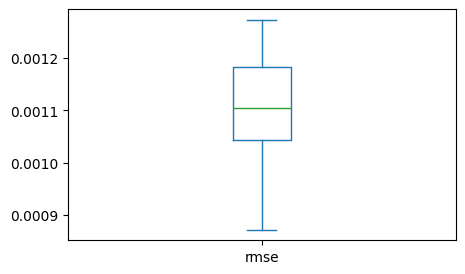

In [11]:
# plot rmse
fig, ax = plt.subplots(figsize=(5,3))
pd.concat(perfs_traits_sims)['rmse'].plot(kind='box', ax=ax)
pass

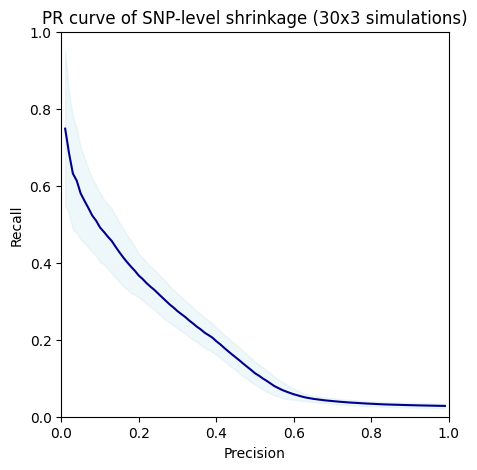

In [12]:
# plot PRC
plt.figure(figsize=(5,5))
avg = np.vstack(prec_traits_sims).mean(axis=0)[1:-1]
plt.plot(base_rec[1:-1], avg, color='darkblue')
std_dev = np.vstack(prec_traits_sims).std(axis=0)[1:-1]
plt.fill_between(base_rec[1:-1], avg - std_dev, avg + std_dev, 
                 color='lightblue', alpha=0.2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("Recall")
plt.xlabel("Precision")
plt.title("PR curve of SNP-level shrinkage ({}x{} simulations)".format(n_sim,n_traits))
pass